## Setting up Quickmet

In [41]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
import sys
sys.path.append("..")

In [6]:
from rom_tools import rom_manager
from rom_tools.address import Address
# make_starting_items doesn't work, because quickmet doesn't read from the required locations.
#TODO: make a function like this that takes an itemset, etc.
from rom_tools.rom_edit import make_starting_items, beam_codes, item_codes

In [7]:
rom = rom_manager.RomManager("../../roms/sm_clean.smc", "../../roms/sm_quicked.sfc", mod=False)

In [8]:
rom.apply_ips("../patches/sm_quickmet.ips")

In [9]:
#room_id = 0x92fd
room_id = 0xac5a
#samus_x = 0x0070
#samus_y = 0x0078
samus_x = 0x00100
samus_y = 0x0080
room_id_address = Address(0x59ad0)
samus_x_address = Address(0x59a8a)
samus_y_address = Address(0x59a90)
# Destination room tile, to make the camera work properly
dx_address = Address(0x59ad6)
dy_address = Address(0x59ad7)

print(hex(int.from_bytes(rom.read_from_new(samus_x_address, 2), byteorder="little")))
print(hex(int.from_bytes(rom.read_from_new(samus_y_address, 2), byteorder="little")))

0x70
0x78


In [10]:
def to_bytes(i):
    return i.to_bytes(2, byteorder="little")

In [11]:
samus_x_address, samus_y_address
to_bytes(samus_x), to_bytes(samus_y)

(b'\x00\x01', b'\x80\x00')

In [12]:
rom.write_to_new(room_id_address, to_bytes(room_id))
rom.write_to_new(samus_x_address, to_bytes(samus_x))
rom.write_to_new(samus_y_address, to_bytes(samus_y))
rom.write_to_new(dx_address, (samus_x // 0x100).to_bytes(1, byteorder="little"))
rom.write_to_new(dy_address, (samus_y // 0x100).to_bytes(1, byteorder="little"))

print(hex(int.from_bytes(rom.read_from_new(samus_x_address, 2), byteorder="little")))
print(hex(int.from_bytes(rom.read_from_new(samus_y_address, 2), byteorder="little")))

0x100
0x80


In [13]:
# This doesn't work.
#make_starting_items("E99", rom)

In [14]:
rom.save_and_close()

In [15]:
import retro
import gzip

In [16]:
if "emu" in locals():
    del emu

In [17]:
emu = retro.RetroEmulator("../../roms/sm_quicked.sfc")
gamedata = retro.data.GameData()
emu.configure_data(gamedata)
# Wait until the game loads from SRAM
load_wait = 256
#load_wait = 300
#load_wait = 350
total_wait = 416
for i in range(load_wait):
    emu.step()

In [18]:
# Configure memory
mem_offset = emu.get_state().index(gamedata.memory.blocks[0x7E0000])
# 09c2, 09c4, samus health
state = bytearray(emu.get_state())
frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x09c2)[0] = 99
frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x09c4)[0] = 99
# Set X and Y
#frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x0af6)[0] = 0x300
#frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x0afa)[0] = 0x180
hacked_state = bytes(state)
emu.set_state(hacked_state)
emu.step()
state = emu.get_state()
# Check energy and max energy
print(frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x09c2)[0])
print(frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x09c4)[0])
# Check x and y
print(frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x0af6)[0])
print(frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x0afa)[0])

99
99
0
0


In [19]:
#screens = []
for i in range(total_wait - load_wait):
#    if i % 10 == 0:
#        screens.append(emu.get_screen())
    emu.step()
    state = emu.get_state()
    #print(i)
    s_energy = frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x09c2)[0]
    s_max_energy = frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x09c4)[0]
    samus_x = print(frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x0af6)[0])
    if s_energy == 0:
        matshow(emu.get_screen())
        break
state=emu.get_state()
print(frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x0af6)[0])
print(frombuffer(state, dtype='<u2', count=1, offset=mem_offset+0x0afa)[0])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
259
7
11
15
19
23
27
31
35
39
43
47
51
55
59
63
67
70
74
78
82
86
90
94
98
102
106
110
114
118
122
126
130
133
137
141
145
149
153
157
161
165
169
173
177
181
185
189
193
196
200
204
208
212
216
220
224
228
232
236
240
244
248
252
256
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
263
128


In [20]:
0x70, 0x78

(112, 120)

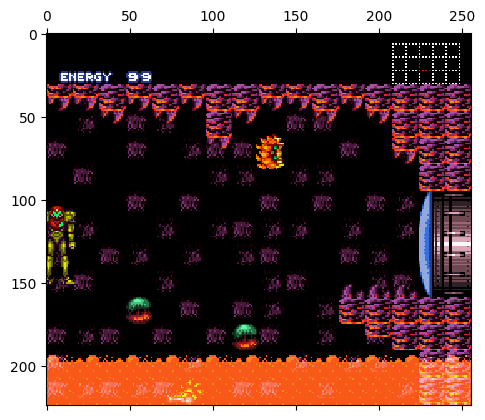

In [21]:
matshow(emu.get_screen())

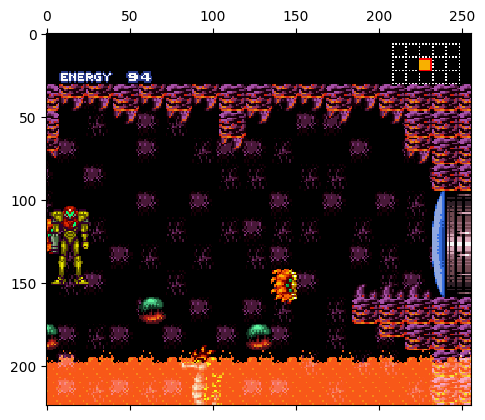

In [22]:
for i in range(20):
    emu.step()
matshow(emu.get_screen())

In [23]:
#for i in screens:
#    matshow(i)
    
# around frame 400 - 410

In [24]:
from abstraction_validation import abstractify
from world_rando.coord import Coord

In [25]:
ammo_locs = {"E": (0x09c2, 0x09c4), "M": (0x09c6, 0x09c8), "S": (0x09ca, 0x09cc), "PB": (0x09cd, 0x09d0)}
ammo_amounts = {"E": 100, "M": 5, "S": 5, "PB": 5}

In [26]:
# Regions (in order): Crateria, Brinstar, Norfair, Wrecked_Ship, Maridia, Tourian, Ceres, Debug
# Boss_ID -> (Region, Bitmask)
boss_info = {"Kraid": 0}

In [27]:
def ram_write(state, address, data):
    frombuffer(state, dtype='<u2', count=1, offset=address)[0] = data

In [28]:
def make_beams_int(item_set, is_equipped=False):
    bitmask = 0
    for i in item_set:
        if i in beam_codes:
            bitmask += beam_codes[i]
    # De-equip spazer if plasma beam is equipped. Firing while spazer and plasma are both equipped will crash the game
    if is_equipped and "PLB" in item_set and "Spazer" in item_set:
        bitmask -= beam_codes["Spazer"]
    return bitmask

def make_items_int(item_set):
    bitmask = 0
    for i in item_set:
        if i in item_codes:
            bitmask += item_codes[i]
    return bitmask

In [29]:
# Goes from SamusState plus additional info to an actual game state.
# Won't preserve stuff like pose, unfortunately.
# Deletes emulator instance since only one at a time is possible.
# Extra_items is of the form {i_type: amount}
def reify_state(rom_path, temp_rom_path, samus_state, room_id, room_offset, is_local, extra_items={"E": 99}):
    # Update the ammo amounts based on the item set
    for ammo_item in ammo_locs.keys():
        if ammo_item in samus_state.items:
            if ammo_item not in extra_items:
                extra_items[ammo_item] = ammo_amounts[ammo_item]
            else:
                extra_items[ammo_item] += ammo_amounts[ammo_item]
    # Set up the quickmet ROM
    rom = rom_manager.RomManager(rom_path, temp_rom_path, mod=False)
    rom.apply_ips("../patches/sm_quickmet.ips")
    if is_local:
        p = samus_state.position
    else:
        # Compute the local offset
        p = samus_state.position - room_offset
    samus_x = p.x * 0x10
    samus_y = (p.y + 1) * 0x10 # +1 because the samus Y here is the center, but abstract samus Y is the top.
    print(samus_x, samus_y)
    rom.write_to_new(room_id_address, to_bytes(room_id))
    rom.write_to_new(samus_x_address, to_bytes(samus_x))
    rom.write_to_new(samus_y_address, to_bytes(samus_y))
    rom.write_to_new(dx_address, (samus_x // 0x100).to_bytes(1, byteorder="little"))
    rom.write_to_new(dy_address, (samus_y // 0x100).to_bytes(1, byteorder="little"))
    # Set up the emulation
    emu = retro.RetroEmulator(temp_rom_path)
    gamedata = retro.data.GameData()
    emu.configure_data(gamedata)
    # Wait for the ROM to write values from SRAM
    for i in range(256):
        emu.step()
    state = bytearray(emu.get_state())
    # Set up RAM data (Samus Items, Energy, Missiles, etc.)
    mem_offset = emu.get_state().index(gamedata.memory.blocks[0x7E0000])
    # Write ammo amounts
    for item_type, amount in extra_items.items():
        current_addr, max_addr = ammo_locs[item_type]
        for address in [current_addr, max_addr]:
            ram_write(state, mem_offset + address, amount)
    # Write item bitset
    # 0x9a2 and 0x9a4 equipped / collected
    item_bitmask = make_items_int(samus_state.items)
    ram_write(state, mem_offset + 0x09a2, item_bitmask)
    ram_write(state, mem_offset + 0x09a4, item_bitmask)
    # Write beam bitset
    # 0x9a6 and 0x9a8 (make sure to exclusify plasma / spazer)
    beams_equipped = make_beams_int(samus_state.items, is_equipped=True)
    beams_collected = make_beams_int(samus_state.items)
    ram_write(state, mem_offset + 0x09a6, beams_equipped)
    ram_write(state, mem_offset + 0x09a8, beams_collected)
    # Write bosses
    # 0xd820 for event set
    # 0x7ed828 + (region_id) for bosses
    # 0x7ed828 - 0x7ed82f is 7 single bytes (one per region)
    # Wait for gameplay to start
    hacked_state = bytes(state)
    emu.set_state(hacked_state)
    for i in range(156):
        emu.step()
    # Return the state
    end_state = emu.get_state()
    end_screen = emu.get_screen()
    del emu
    return end_state, end_screen

In [33]:
from abstraction_validation.quickmet import reify_state

In [34]:
from world_rando.rules import HVelocity, Velocity, VType, SamusPose, SamusState
from data_types.item_set import ItemSet

In [35]:
# Local SamusState for 0x7965b
vh = HVelocity(VType.RUN, 0)
v = Velocity(0, vh)
itemset = ItemSet(["MB", "GS", "SA", "B"])
#samus_state = SamusState(Coord(92, 7), v, itemset, SamusPose.STAND) # Gauntlet
samus_state = SamusState(Coord(47, 10), v, itemset, SamusPose.STAND)

In [36]:
import gc

In [60]:
#del emu
gc.collect()

1805

In [61]:
reify_state.__module__

'abstraction_validation.quickmet'

In [62]:
#g_state, g_image = reify_astate("../../roms/sm_clean.smc", "../../roms/sm_in_gauntlet.sfc", samus_state, 0x965b, None, True, extra_items={"E":599})
g_state, g_image = reify_state("../../roms/sm_clean.smc", "../../roms/sm_in_parlor.sfc", samus_state, 0x92fd, None, True, extra_items={"E":599})

/mnt/d/Ross/Programming/sm door rando/sm_rando/notebooks/../abstraction_validation/quickmet.py
/mnt/d/Ross/Programming/sm door rando/sm_rando/notebooks/..
752 176


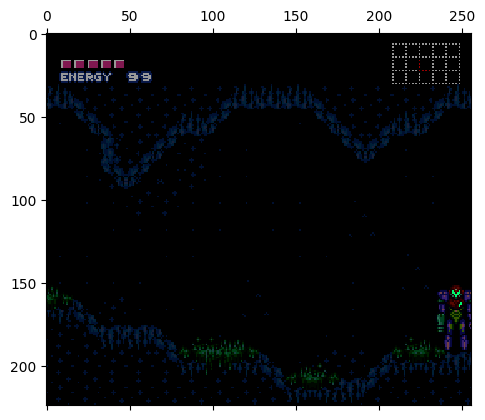

In [63]:
matshow(g_image)

In [111]:
mem_offset = emu.get_state().index(gamedata.memory.blocks[0x7E0000])

NameError: name 'emu' is not defined

## Setting up Abstract Scenario

In [112]:
#TODO: move some of this setup stuff into go_explore.py

In [113]:
rom_m = rom_manager.RomManager("../../roms/sm_clean.smc", "../../roms/sm_generate.smc")
obj_names = rom_m.parse()

In [114]:
from world_rando import parse_rules
from world_rando import model_checking

In [41]:
def room_image(ptr):
    room_header = obj_names[f"room_header_{ptr}"]
    l = parse_rules.make_level_from_room(room_header)
    return l, l.to_image()

In [727]:
# Gauntlet Back
gauntlet_back_lstate, gauntlet_back_image = room_image("0x7965b")
# Hack to "fix" (19, 5)
#TODO: should "fix" the movement model instead!
gauntlet_back_lstate.level.flags.writeable = True
gauntlet_back_lstate.level[Coord(19,5)] = 1
gauntlet_back_lstate.level.flags.writeable = False
gauntlet_back_image = gauntlet_back_lstate.to_image()
gauntlet_back_image

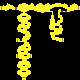

In [57]:
# Gauntlet Back
parlor_lstate, parlor_image = room_image("0x792fd")
parlor_image

In [193]:
#final_state = SamusState(Coord(0, 7), v, itemset, SamusPose.STAND) # Gauntlet
final_state = SamusState(Coord(62, 40), v, itemset, SamusPose.STAND)

In [178]:
rules, tests = parse_rules.parse_rules(["../encoding/rules/rules.yaml",
                                        "../encoding/rules/model_checking_tests/model_checking_tests.yaml"])

In [179]:
samus_state
#(c(23,9)|V: 0, H: RUN, 0|STAND|ISet([]))
#TODO: Problem with a no-liquid level?

(c(47,10)|V: 0, H: RUN, 0|STAND|ISet(['B', 'SA', 'GS', 'MB']))

In [192]:
initial_states, k = model_checking.make_kripke(samus_state, final_state, parlor_lstate, rules.values())

TypeError: unhashable type: 'list'

In [194]:
samus_state in k.states(), final_state in k.states()
kf = [k for k in k.states() if k.position == Coord(62, 40)]
final_state = kf[0]

In [195]:
import networkx as nx

In [196]:
# Create forward + backward graph
G = nx.Graph()
G2 = nx.Graph()
for (n1, n2) in k.edges_iter():
  G.add_edge(n1, n2)
  G2.add_edge(n2, n1)

In [197]:
model_states = list(k.states())
model_positions = [s.position for s in model_states]

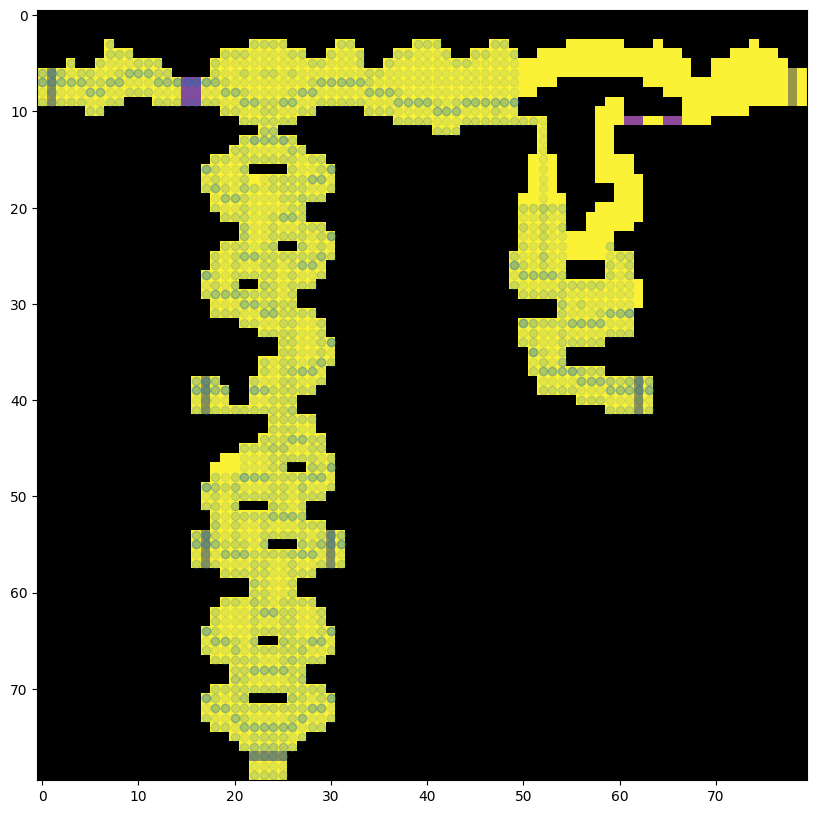

In [198]:
figure(figsize=(10,10))
scatter(*array(model_positions).T, alpha=0.1)
gca().set_aspect("equal")
gca().invert_yaxis()
#gca().imshow(gauntlet_back_image)
gca().imshow(parlor_image)
# At this point it should be pretty clear that the jumping model is flawed...

In [199]:
def get_distances(G, state):
  distances = {state: 0}
  for (v, u) in nx.algorithms.traversal.bfs_predecessors(G, state):
    distances[v] = distances[u] + 1
  return distances

In [200]:
source_distances = get_distances(G, samus_state)
final_distances = get_distances(G2, final_state)
shared_distances = {k: source_distances[k] + final_distances[k] for k in source_distances.keys()}
shortest_path_distance = min(shared_distances.values())

## Go Explore

In [201]:
from abstraction_validation.abstractify import *
from abstraction_validation.go_explore import *

In [204]:
emu = retro.RetroEmulator("../../roms/supermetroid.sfc")
gamedata = retro.data.GameData()
emu.configure_data(gamedata)

In [205]:
emu.set_state(g_state)

True

In [206]:
model_states = list(k.states())
slop = 4
good_model_states = [s for s in model_states if shared_distances[s] <= shortest_path_distance + slop]
cell_ok = mk_cell_ok(good_model_states, 2, Coord(0,0))

In [207]:
cell_dist = mk_cell_dists(good_model_states, final_distances, Coord(0,0))
cell_dist_selector = SoftminSelector(cell_dist, 3)

In [210]:
#def end_goal(abstract_state):
#    return abstract_state.position.x < 5
def end_goal(abstract_state):
    return abstract_state.position.y == 40 and abstract_state.position.x == 42

In [164]:
# Use the inputs from the blue brinstar movie
# TODO: need to make another movie
movie = retro.Movie("../abstraction_validation/blue_brinstar.bk2")
movie_start = movie.get_state()
emu.set_state(movie_start)
emu.step()
frames = []
rams = []
special_rams = []
inputs = []
while movie.step():
    keys = []
    for i in range(12):
      keys.append(movie.get_key(i, 0))
    inputs.append(tuple(keys))
    frames.append(emu.get_screen())
    rams.append(np.frombuffer(gamedata.memory.blocks[0x7e0000],'uint8'))
    special_rams.append(frombuffer(gamedata.memory.blocks[0], dtype=np.uint8))
    emu.set_button_mask(keys,0)
    emu.step()
rams = array(rams)

In [165]:
#TODO: what is wrong with this cell_ok?

In [211]:
#atlas, graph, _, _, log, n_frames = go_explore(g_state2, list(set(inputs)), emu, gamedata, 400, 20, cell_ok=cell_ok, goal=end_goal, cell_selector=cell_dist_selector, global_pos=False, seed=0)
#atlas, graph, _, _, log, n_frames = go_explore(g_state2, list(set(inputs)), emu, gamedata, 2000, 20, goal=end_goal, cell_selector=cell_dist_selector, global_pos=False, seed=0)
atlas, graph, _, _, log, n_frames = go_explore(g_state, list(set(inputs)), emu, gamedata, 2000, 20, goal=end_goal, cell_selector=cell_dist_selector, global_pos=False, seed=0)

(c(47,11)|V: 0, H: RUN, 0|MORPH|ISet(['B', 'SA', 'GS', 'MB', 'E']))


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 82.57step/s]


In [212]:
len(atlas.keys())

75

In [213]:
#del atlas, graph, log
#gc.collect()

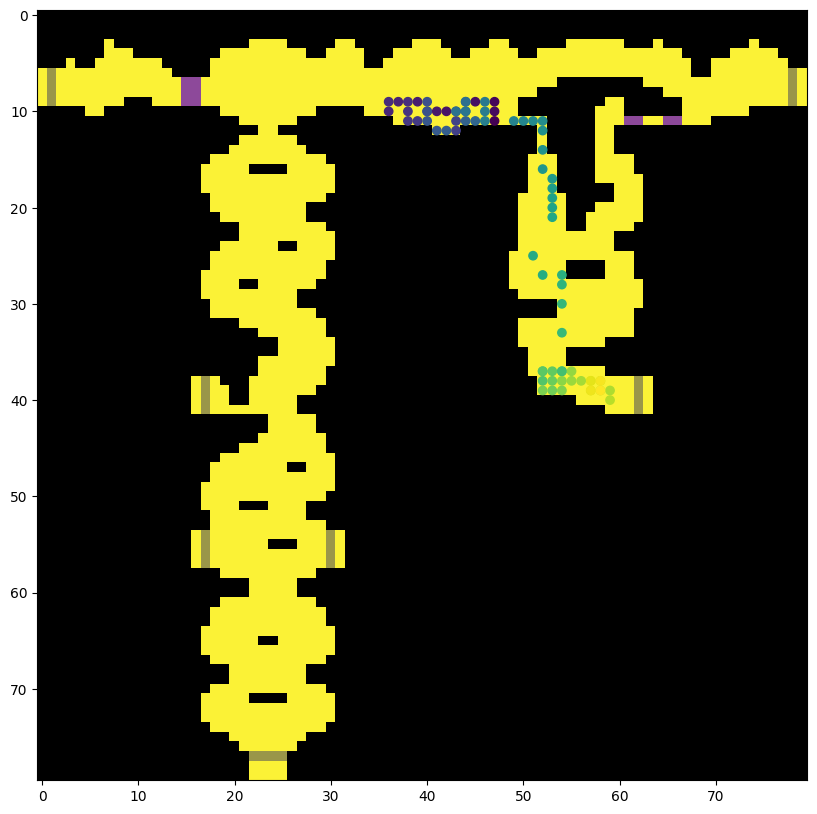

In [217]:
good_model_positions = [s.position for s in good_model_states]
figure(figsize=(10,10))
#TODO: the colors are wrong because of stacking
scatter(*np.array([a.position for a in atlas.keys()]).T, c=arange(len(atlas.keys())), cmap="viridis")
#scatter(*array(good_model_positions).T, alpha=0.1)
#scatter(*array(model_positions).T, alpha=0.1)
gca().set_aspect("equal")
gca().invert_yaxis()
#gca().imshow(gauntlet_back_image)
gca().imshow(parlor_image)

In [221]:
def score(node):
    ram = graph.nodes[node]["ram"]
    s = abstractify_state(ram)
    return abs(s.position.x - 62) + abs(s.position.y - 40)

source = list(graph.nodes)[0]
#target = max(graph.nodes, key=score)
target = min(graph.nodes, key=score)
p = nx.shortest_path(graph, source, target)

In [222]:
import IPython.display

Length: 99 states, 991 frames


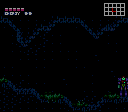

In [223]:
resim_and_write(emu, p, graph, fname="../output/sm.gif", framespeed=4, imscale=2)
IPython.display.Image(filename="../output/sm.gif")

In [100]:
len(list(set(inputs)))

25

## Debugging

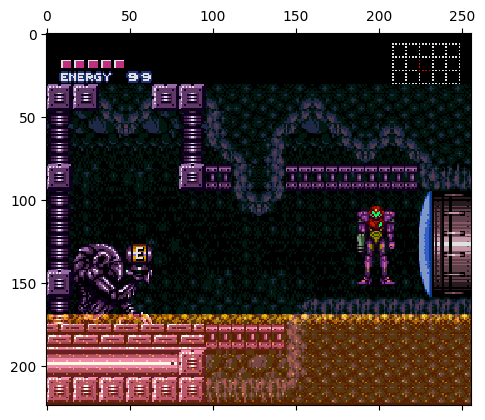

In [783]:
emu.set_state(g_state)
emu.step()
matshow(emu.get_screen())

In [784]:
#TODO Put this somewhere in abstraction validation

In [785]:
SNES_BUTTON_NAMES = ["B", "Y", "SELECT", "START", "UP", "DOWN", "LEFT", "RIGHT", "A", "X", "L", "R"]
locals().update(zip(SNES_BUTTON_NAMES, eye(12)))

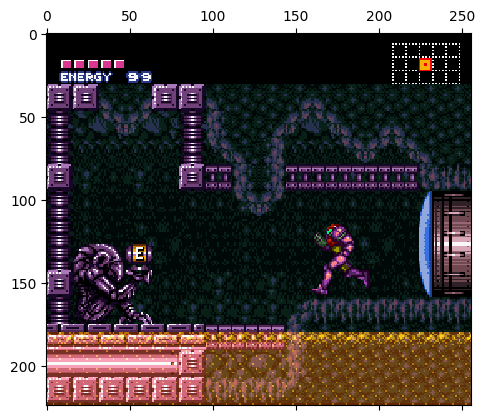

In [791]:
for i in range(10):
    emu.set_button_mask(LEFT)
    emu.step()
matshow(emu.get_screen())
g_state2 = emu.get_state()